## <center> A2: Bias in Data </center>
 <center> Sharmeelee Bijlani </center>
  <center> DATA 512 </center>
 <center> October 19, 2020 </center>

## Tutorial: Perform Exploratory Data Analysis of Bias in Wikipedia Talk Labels
This notebook goes through the steps of exploring two annotated datasets used by Google data scientist as part of a project called Conversation AI. The analysis aims to identify sources of bias in the datasets that may propogate through any machine learning models trained with this data. 

This tutorial uses the toxicity and personal attacks dataset procured from Wikipedia talk label. Two hypotheses are presented and tested for bias in the steps below. Finally, visulizations of the analysis and a conclusion of the implications of bias are discussed in the notebook.

## Step 0: Background research

First, we need to download and import the datasets located in the github repo as well as at this link: https://figshare.com/projects/Wikipedia_Talk/16731. Download the datasets, save and read the .csv files as pandas dataframes which will be used for data preperation and analysis later in the tutorial.

I chose to analyze the datasets with labels of personal attacks and toxicity because while personal attacks seem to be a very specific type of hostile comments, toxicity encompasses a much wider scope of comments. I want to understand if there are differences in the way workers percieve these labels and whether that affects the labeling process. For example, I would label something as toxic if I felt it has a general negative connotation. But I would only label something as a personal attack if I felt it was directed only at me. Due to the difference in being personalized and generalized, I assume that the toxic label is more widely applicable to comments than the personal attack label. 

In [1]:
# import the data
import pandas as pd

attack_comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
attack_annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')
attack_workers = pd.read_csv('attack_worker_demographics.tsv',  sep = '\t')

toxic_comments = pd.read_csv('toxicity_annotated_comments.tsv', sep = '\t', index_col = 0)
toxic_annotations = pd.read_csv('toxicity_annotations.tsv',  sep = '\t')
toxic_workers = pd.read_csv('toxicity_worker_demographics.tsv',  sep = '\t')

## Step 1: Select and perform analysis

### Research Question 1: 
Are certain words more likely to be associated with comments labelled as hostile speech? Are there certain words that are frequently associated with one type of hostile speech (like “personal attacks”) but not others (like “toxicity”)?

I want to perform this analysis to test whether there is a difference in the understanding of personal attack and toxicity based on usage of words. Although, both are types of hostile comments, there is a subtle difference in the interpretation of personal attack and toxicity. I want to test if we can detect a difference in the correlation of words used in comments for each label. 

The first part of the analysis requires a significant amount of data preperation. We will start by ignoring warnings caused by large amounts of data and performance issues specific to your local compute or server.

In [2]:
import warnings
warnings.filterwarnings('ignore')

For this analysis, we will need to use the comments and annotations datasets for each hostility type (personal attacks and toxicity). Since the common column between the two datasets is rev_id or the unique identifier for comments, we will perform an inner join on the comments data and annotations data. The definition below takes these two dataframes as inputs and returns a joined dataframe with each comment along with it's hostility label. 

In [3]:
# merge comments df with annotations df
def mergedf(df1, df2):
    df = df1.merge(df2, how='inner', on='rev_id')
    return df

Next, we need to filter out comments that are not labeled as hostile. The labeling process requires workers to label all comments as negative, neutral or positive. The neutral and postive comments will not aid in our analysis of word classification as personal attack or toxic. The definition below only keeps the values in the personal attack or toxicity column which are marked as hostile. 

In [4]:
# filter df for only hostile comments
def filterComments(df, colName):
    df = df[df[colName]==1]
    return df

We need to filter each comment by removing stop words such as 'the', 'this' or other articles which add no value to language connotation. However, each comment is formatted as a string with characters that cannot be processed such as "NEWLINE_TOKEN", punctuation, and capital letters. The definition below removes the characters so that the output is a string of words in all lower case letter with no punctuation. 

In [5]:
def cleanComments(df):
    df['comment'] = df['comment'].str.replace('NEWLINE_TOKEN', '', regex=True)
    df['comment'] = df['comment'].str.replace('[^\w\s]','')
    df['comment'] = df['comment'].str.lower()
    return df

Here we use a natural language processing package called spacy which has a library of words with no definition value called stopwords. The code below imports this library as well as lists and displays the stopwords which we will remove from the comments.

In [6]:
# remove stopwords from dataframe
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

print(len(STOP_WORDS))
print(STOP_WORDS)
stop = STOP_WORDS

326
{'becoming', 'yet', 'afterwards', 'their', 'nine', 'because', 'under', 'various', 'three', 'upon', 'front', 'so', 'against', 'where', "'d", 'am', 'himself', 'above', 'into', 'else', '’ll', 'another', 'quite', 'among', 'then', 'is', 'been', 'out', 'whereby', 'after', 'empty', 'besides', 'you', 'unless', 'neither', 'yourself', 'those', 'we', '‘ll', 'anyone', 'give', 'was', 'did', 'when', 'fifteen', 'hence', 'now', 'onto', 'but', 'that', 'these', 'nor', 'might', 'whose', 'with', 'become', 'on', 'sixty', 'per', "'m", 'something', 'alone', "'re", 'she', 'otherwise', 'towards', 'third', 'regarding', 'behind', 'other', 'whither', 'doing', 'just', 'will', 'whereafter', 'her', 'ten', 'wherein', 'much', 'must', 'whenever', 'each', 'whatever', 'two', 'throughout', 'show', 'thus', '’ve', '’m', 'due', 'had', 're', 'do', 'became', 'very', 'your', 'its', 'therefore', 'either', 'again', 'n’t', 'noone', 'seemed', 'many', 'namely', 'nothing', 'ca', 'here', 'about', 'most', 'thereupon', 'why', 'betwe

The definition below uses the list of stopwords created above and filters them out of the comments.

In [7]:
# remove stop words from comments
def removeStop(df):
    df['comment'] = df['comment'].str.split(' ').apply(lambda x: ' '.join(k for k in x if k not in stop))
    return df

The definition below finds the most frequently occuring words in each joined dataframe. We can use the output list of the top most frequent words for our analysis and comparision of personal attacks and toxicity. 

In [8]:
# find words with highest frequency
def topNwords(df, N):
    return pd.Series(' '.join(df.comment).split()).value_counts()[:N]

Now that each step of the data processing is defined. We will run the personal attack and toxicity dataframes through each step resulting in two seperate lists of the most-frequently appearing words in each hostility type. I am using 20 as the 'N' parameter for easy displaying purposes in the charts that will be created later in the tutorial. 

In [9]:
# find top words in personal attacks
attack_df = mergedf(attack_comments, attack_annotations)
attack_filtered = filterComments(attack_df, 'attack')
attack_clean = cleanComments(attack_filtered)
attack_df = removeStop(attack_clean)
attack_top_words = topNwords(attack_df, 20)
attack_top_df = attack_top_words.to_frame()

The top 20 words are plotted in a bar chart as seen below. I am using the matplotlib package which is commonly used to visualize dataframes. 

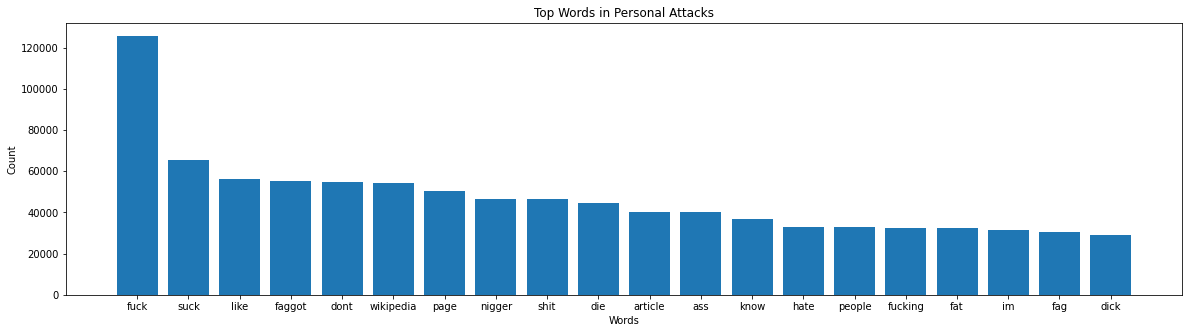

In [10]:
# plot bar chart of words vs. count - personal attack
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.bar(attack_top_df.index, attack_top_df[0])
plt.title("Top Words in Personal Attacks")
plt.xlabel("Words")
plt.ylabel("Count")
plt.savefig("TopWordsInPersonalAttacks.png")

Repeat the data processing steps for the toxicity dataframe. This outputs the top 20 words used in comments labeled as toxic. 

In [11]:
# find top words in toxicity
toxic_df = mergedf(toxic_comments, toxic_annotations)
toxic_filtered = filterComments(toxic_df, 'toxicity')
toxic_clean = cleanComments(toxic_filtered)
toxic_df = removeStop(toxic_clean)
toxic_top_words = topNwords(toxic_df, 20)
toxic_top_df = toxic_top_words.to_frame()

Plot the top 20 words used in toxicity dataframe in a bar chart the same way we plotted the data for personal attacks. We can use these charts to compare the results and detect differences. 

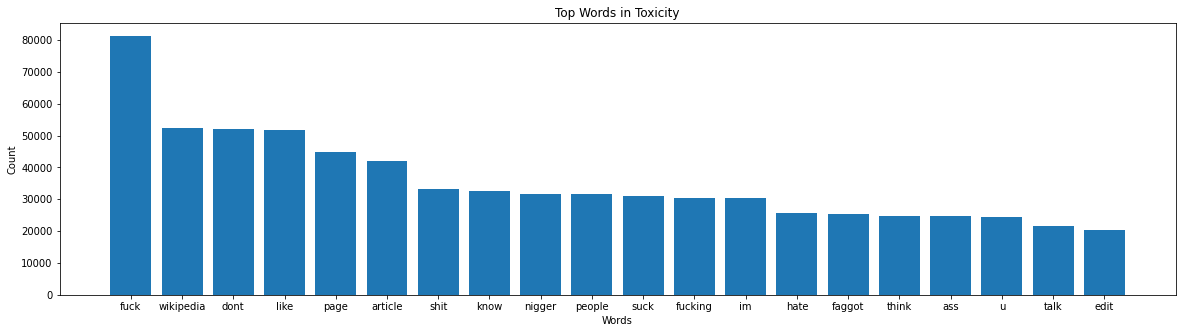

In [12]:
# plot bar chart of words vs. count - toxicity
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.bar(toxic_top_df.index, toxic_top_df[0])
plt.title("Top Words in Toxicity")
plt.xlabel("Words")
plt.ylabel("Count")
plt.savefig("TopWordsInToxicity.png")

Next, we want to enable a comparison of the most frequently used words side-by-side. This requires joining the personal attacks and toxicity data. We can use the merge function defined above since the primary key is still the unique identifier for comments. 

In [13]:
# merge datasets
hostile_comments = mergedf(attack_df, toxic_df)

Now, we use the merged dataset with to find the most frequently used words in comments labeled as hostile. Here, we use hostile as a category of language that encompasses both personal attacks and toxicity. 

In [14]:
# find top words in combined (hostile)
hostile_top_words = topNwords(toxic_df, 20)
hostile_top_df = toxic_top_words.to_frame()
hostile_top_csv = hostile_top_df.to_csv('TopHostileWords.csv')

A similar-looking bar chart is created to display the frequency words in hostile comments. We can use the three charts created so far to compare correlations between words and type of hostility. 

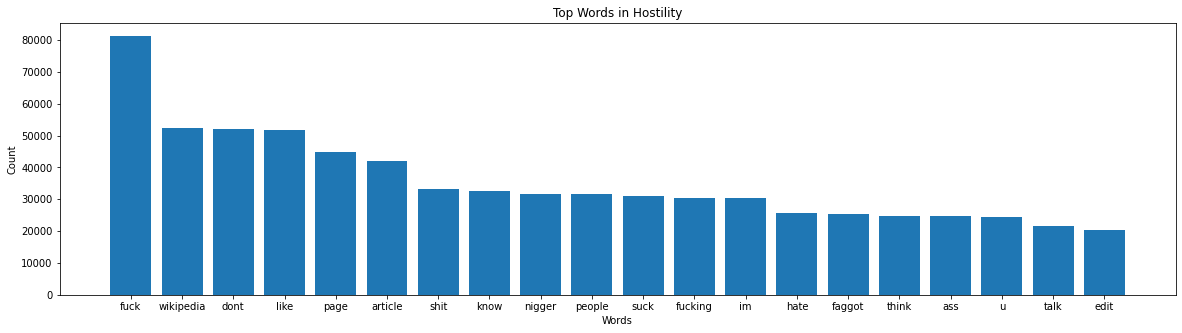

In [15]:
# plot bar chart of words vs. count - hostility
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.bar(hostile_top_df.index, hostile_top_df[0])
plt.title("Top Words in Hostility")
plt.xlabel("Words")
plt.ylabel("Count")
plt.savefig("TopWordsInHostility.png")

Finally, we can dive deeper into our analysis by enabling side-by-side comparison of the types of hostility by word usage frequency. I am using a stacked bar chart with color-encoded hostility type to visualize this comparison. 

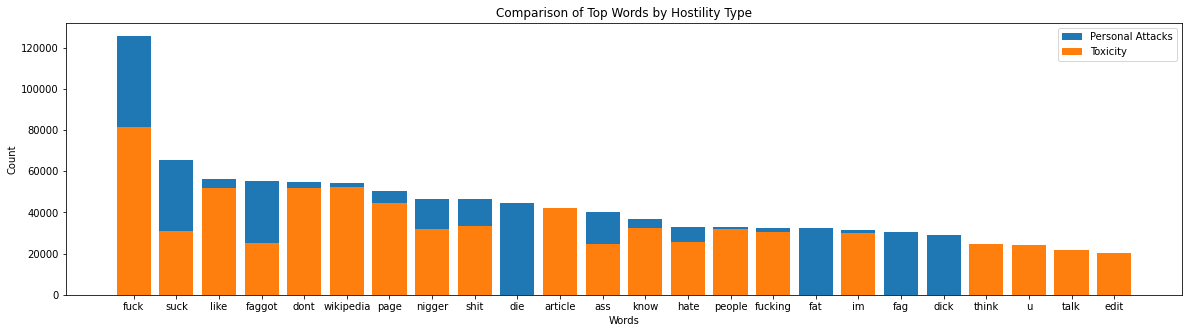

In [16]:
# plot bar chart of words vs. count with hostility type encoded
plt.figure(figsize=(20, 5))
p1 = plt.bar(attack_top_df.index, attack_top_df[0])
p2 = plt.bar(toxic_top_df.index, toxic_top_df[0])
plt.legend((p1[0], p2[0]), ('Personal Attacks', 'Toxicity'))
plt.title("Comparison of Top Words by Hostility Type")
plt.xlabel("Words")
plt.ylabel("Count")
plt.savefig("ComparisonofTopWords.png")

### Implications:
What are the findings?
Did you find bias?
Did you not?

The analysis of each individual dataframe of hostility type indicates that the most frequently used words are commonly associated with hostile speech as there is significant overlap between the top words in the personal attacks dataset, in the toxicity dataset, and in the combined dataset. As indicated by the fourth figure, 17 of the top 20 most frequently used words in hostile speech were found in both datasets. However, there is a detectable difference in the words associated with different types of hostility. The stacked bar chart indicates that some words such as 'die' were only labeled with personal attacks, and not toxicity. This confirms the hypothesis that personal attacks are percieved differently by labelers than toxicity and some words are directly correlated with a specific type of hostility. Similarly, the stacked bar chart also depicts how some words like 'hate'or 'dont' are mostly found in comments labeled as toxic indicating that general purpose words with negative connotation are considered toxic rather than targeted personal attack. 

This analysis does not indicate a bias that would be harmful for any model trained with this data because the words found to be associated with hostility are legitimately negative. There are racial slangs, profanity as well as abusive language found in the list of frequently used words labeled as hostile. This would hold true for any English-based domain or application. 

Are these words representative of words that you would associate with hostile speech? Do you think these frequently labelled words are a good representation of hostile speech in online discussions outside of Wikipedia? Of offline discussions? Why or why not?

The third figure derived from this analysis represents the top 20 words that are associated with hostile speech based on the labels for comments. Eight of the top 20 words have a negative denotation as well as connotation. The remaining words are either generic to the domain such as article or wikipedia or filler words. This shows that these frequently labeled words are indeed a good representatoin of hostile speech. The same conclusion applies to online as well as offline discussion and this indicates the data can be used for training models in various applications that deal with natural language processing. 

### Research Question 2: 
Are different demographic profiles of workers more sensitive to one type of hostile speech than another? For example, do women more frequently label comments as personal attacks than men? Is there higher frequency of female workers labelling comments as personal attacks rather than toxic?

The motivation for this analysis is to understand the effect of demographics of workers who label comments on the annotations. Personal attacks and toxicity are both considered hostile, but affect readers differently. In this case, since the readers and labelers are the workers, understanding their demographics and any biases they have can be used to improve any model that would be trained on this data. I want to understand how different males and females would react to personal attacks versus toxicity and whether or not they percieve the two as any different. For example, it is commonly assumed that women take things more personally, which is why my hypothesis is that women would more frequently label comments as personal attacks than men. This analysis will test this assumption. 

In order to analyze the worker demographics' effect on annotations, we need to join the demographics and annotations dataframes. However, there is no common unique identifier between the two dataframes. Therefore, we need to aggregate the annotations by worker_id. In the defintion below, I am summing the annotations by each unique worker.

In [17]:
# aggregate annotations by worker
def aggregatedf(df):
    df = df.groupby('worker_id').sum()
    return df

Now that the annotations dataset has annotations grouped by worker_id, we can join it with the demograpics dataset on the unique identifier of worker_id. The defintion below takes the aggregated annotation dataframe and the demographics dataframe and outputs the joined dataframe. 

In [18]:
# left join annotations and workers df
def joindf(df1, df2):
    df = df1.merge(df2, how='inner', on='worker_id')
    return df

My analysis question is related to understanding the difference in how males and females label comments. The dataset includes male, female, and other as genders, however, there are only two datapoints with 'other'. Since 'other' does not contribute to the research question, the definition below removes these values from the joined dataframe. 

In [19]:
# filter df to remove other gender 
def filterWorkers(df):
    df = df[df['gender']!='other']
    return df

The processing required to visualize each hostility type is completed and we can pass each datafreme into the definitions. The code below outputs the final dataframe which will be used for visualization and analysis of personal attacks. 

In [20]:
# pass the personal attacks dataframe into each defintion
attack_aggregate = aggregatedf(attack_annotations)
attack_join = joindf(attack_aggregate, attack_workers)
attack_final = filterWorkers(attack_join)
attack_csv = attack_final.to_csv("PersonalAttacksAggregate.csv")

Similarly, we pass the joined dataframe for toxicity into the data processing definitions for further analysis below. 

In [21]:
# pass the toxicity dataframe into each definition
toxic_aggregate = aggregatedf(toxic_annotations)
toxic_join = joindf(toxic_aggregate, toxic_workers)
toxic_final = filterWorkers(toxic_join)
toxic_csv = toxic_final.to_csv("ToxicityAggregate.csv")

We will use the seaborn package to visualize the relationship between worker demographics and annotations as seen in the code below. I am using a swarmplot which plots every datapoint to display a distribution of frequency. Here the type of hostility is encoded in color. 

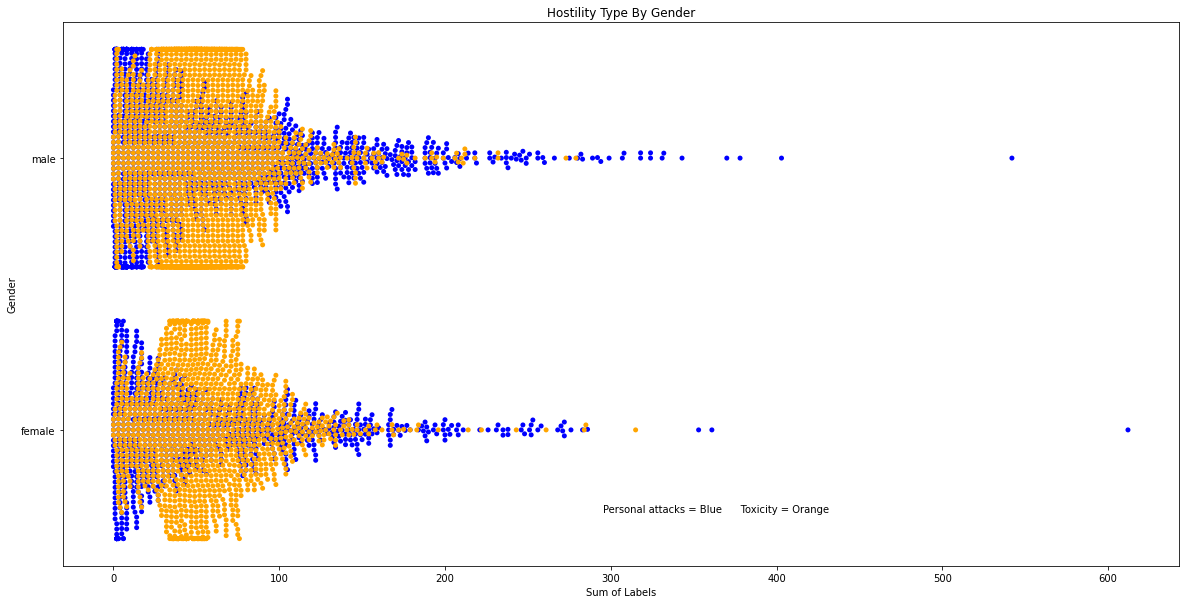

In [22]:
# plot gender demographics - personal attacks
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.swarmplot(y='gender', x='attack', data=attack_final, color='blue')
sns.swarmplot(y='gender', x='toxicity', data=toxic_final, color='orange')
plt.title("Hostility Type By Gender")
plt.xlabel("Sum of Labels")
plt.ylabel("Gender")
plt.figtext(0.5, 0.2, "Personal attacks = Blue      Toxicity = Orange")
plt.savefig("HostilityTypeByGender.png")

Here I am using violin plots to visualize and compare the distribution of annotations by gender for each label. 

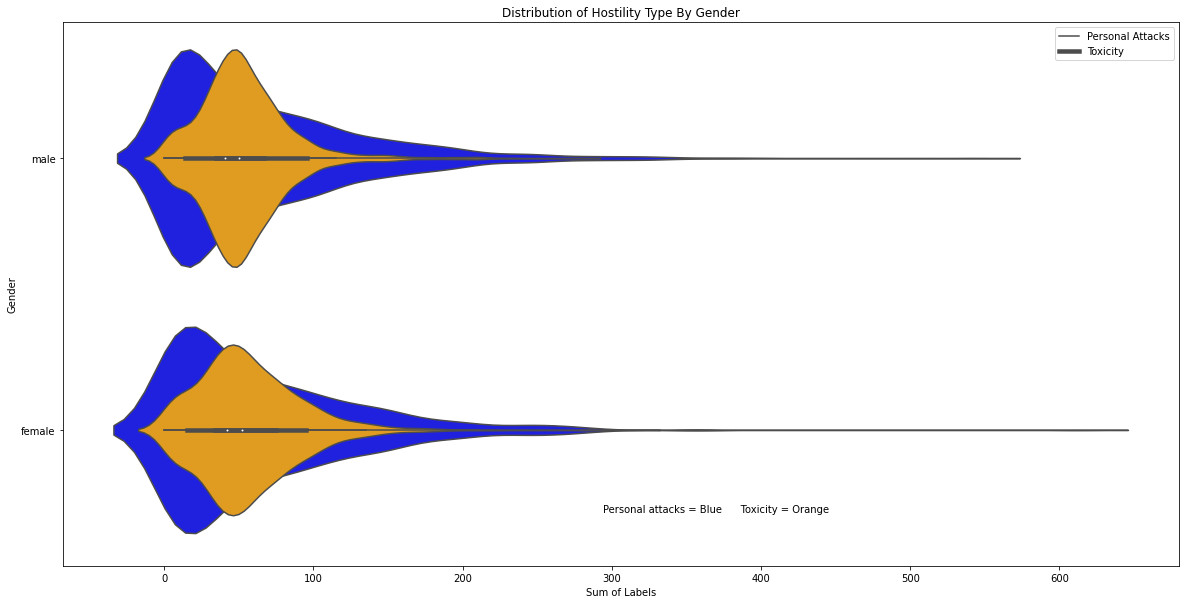

In [23]:
# plot gender demographics
plt.figure(figsize=(20, 10))
sns.violinplot(y='gender',x='attack', data=attack_final, color='blue')
sns.violinplot(y='gender',x='toxicity', data=toxic_final, color='orange')
plt.legend(labels=['Personal Attacks', 'Toxicity'])
plt.title("Distribution of Hostility Type By Gender")
plt.xlabel("Sum of Labels")
plt.ylabel("Gender")
plt.figtext(0.5, 0.2, "Personal attacks = Blue      Toxicity = Orange")
plt.savefig("HostilityTypeDistributionByGender.png")

### Implications: 
What are the findings?
Did you find bias?
Did you not?

The first figure of a swarm chart depicts the data points of the aggregated score of hostility with type of hostility encoded in color. From this chart, it is evident that more male workers were sampled in the dataset as seen in the top half of the figure. Interestingly, the toxicity score given by male workers follows a fairly uniform distribution unlike the personal attack data. For females, there is a very different distribution pattern of personal attack score and toxicity score. This indicates that there is a distinction in the way both males and females percieve personal attacks and toxicity. The difference is detectable between the distribution of each label type as well as gender demographic. The second figure of the voilin plot attempts to understand the distinction between the two genders and how they assess hostility by emphasizing the mean and distibution of the datapoints. This analysis indicates that there are differences in how females and males view hostility as indicated by the tails of the charts. But the distribution is similar. 

The analysis indicates that females are more sensitive to personal attacks which is indicated by a higher aggregated score for personal attacks than males. However, this should not cause bias in the models that would be trained on this data as long as females are represented in the workers and resulting annotations. Also, it would be a good test to increase the samples of workers and annotations to see if the same bias of females being more sensitive to personal attacks persists.  

Are the results representative of certain perceptions of gender-based sensitivity? Do you think the worker demographic in the data labeling process would impact the models that use this data? Why or why not?

The second figure depicts a glaring similarity in distribution of hostility score attributed to comments by each gender. Both the male and female genders have similar means of aggregated hostility score as well as a similar variance. Looking deeper at the distinction between types of hostility, some differences can be observed. It is a noteworthy insight that females score higher on toxicity labeling than males, which confirms the perception that females may be more sensitive to personal attacks. The chart indicates no significant difference in how males and females respond to toxicity. The data labelling process, if sampled in the same proportion as in this data, would propogate to a fair model as indicated by this analysis. If there were significant differences found between how women label comments as hostile verus how men label, then further research of the worker sampling process would be required to assess fairness and compensate with skew.  

## Step 2: Discuss further implications

Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?

The Perspective API would perform well in Comment Filter and Comment Slider applications. This is because the labels in the training data accurately pick up on hostile speech. The comment filter could use the indicator variables in the APIs for hostile speech to filter out comments labeled as any hostility type by a model trained on the Wikipedia Talk data. Similarly the comment slider application could also utilize the data in a model which detects hostile comments and queues them for a response. The response could also be generated via a model, but that would require another dataset of approproate responses and annotations for those. 

Which, if any, of these demo applications would you expect the Perspective API to perform poorly in? Why?

The Perspective API would perform poorly in the Toxicity Timeline and Author Perspective for Drupal applications. The toxicity timeline application requires some time features associated to each comments which is not provided in the dataset. The Author persepective application requires more context on the comments such as the author's demographics and the article they are responding to in order to provide appropriate feedback. 

What are some other contexts or applications where you would expect the Perspective API to perform particularly well, or particularly poorly? Why?

The Perspective API models would perform particularly poorly in any application where multiple languages other than English are used since the data only covers articles in English. Also, this data would not perform well on social media filtering applications because it would result in filtering out a lot of opinion-based posts where hostile speech is more subjective. Deciding what is hostile and what is not in such applications such as Twitter would require a much more diverse dataset with various types of comments and workers who annotate them. 